<a href="https://colab.research.google.com/github/Santo1337/Braintumour-/blob/main/Braintumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras import backend as K

import cv2
import shutil
import glob
import os

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data = '/content/gdrive/MyDrive/Colab Notebooks/brain_tumor_dataset'
No_brain_tumor = '/content/gdrive/MyDrive/Colab Notebooks/brain_tumor_dataset/no'
Yes_brain_tumor = '/content/gdrive/MyDrive/Colab Notebooks/brain_tumor_dataset/yes'

In [ ]:
dirlist=[No_brain_tumor, Yes_brain_tumor]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  253    labels:  253


In [ ]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(253,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,/content/gdrive/MyDrive/Colab Notebooks/brain_...,No
1,/content/gdrive/MyDrive/Colab Notebooks/brain_...,No
2,/content/gdrive/MyDrive/Colab Notebooks/brain_...,No
3,/content/gdrive/MyDrive/Colab Notebooks/brain_...,No
4,/content/gdrive/MyDrive/Colab Notebooks/brain_...,No


In [ ]:
print(df['labels'].value_counts())

Yes    155
No      98
Name: labels, dtype: int64


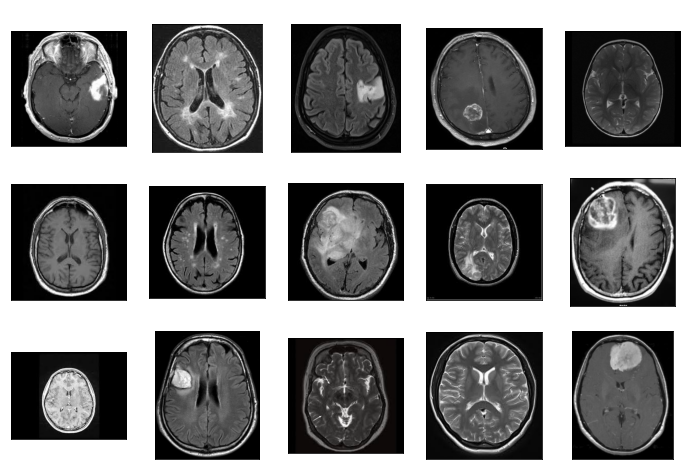

In [ ]:
plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (216, 2)
test set shape: (13, 2)
validation set shape: (24, 2)


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [ ]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (150,150), batch_size = 16, 
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(150,150), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (150,150), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 216 validated image filenames belonging to 2 classes.
Found 24 validated image filenames belonging to 2 classes.
Found 13 validated image filenames belonging to 2 classes.


In [ ]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

In [ ]:
base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', input_shape = (200,200,3),
                                                     include_top=False)
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

219070464/219055592 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
batch_normalization_203 (Bat (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 54,534,113
Trainable params: 54,473,313
N

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', verbose=1),
]


model.compile(loss='binary_crossentropy', optimizer=Adam(lr = 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 40, 
                    callbacks = [callbacks], verbose = 1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/40
14/14 [==============================] - 121s 7s/step - loss: 0.7758 - accuracy: 0.5926 - val_loss: 0.8081 - val_accuracy: 0.5000
Epoch 2/40
14/14 [==============================] - 95s 7s/step - loss: 0.4667 - accuracy: 0.7963 - val_loss: 0.5654 - val_accuracy: 0.7500
Epoch 3/40
14/14 [==============================] - 95s 7s/step - loss: 0.3997 - accuracy: 0.7639 - val_loss: 0.5016 - val_accuracy: 0.7917
Epoch 4/40
14/14 [==============================] - 95s 7s/step - loss: 0.3690 - accuracy: 0.8426 - val_loss: 0.5817 - val_accuracy: 0.7083
Epoch 5/40
14/14 [==============================] - 95s 7s/step - loss: 0.3927 - accuracy: 0.8519 - val_loss: 0.5466 - val_accuracy: 0.7500
Epoch 6/40
14/14 [==============================] - 95s 7s/step - loss: 0.3381 - accuracy: 0.8519 - val_loss: 0.4896 - val_accuracy: 0.7917
Epoch 7/40
14/14 [==============================] - 95s 7s/step - loss: 0.3518 - accuracy: 0.8704 - val_loss: 0.5875 - val_accuracy: 0.7500
Epoch 8/40
14/14 [=

In [ ]:
model.load_weights("Tumor_classifier_model.h5")
model.evaluate(test_gen)

1/1 [==============================] - 1s 1s/step - loss: 0.3477 - accuracy: 0.7692


[0.34765878319740295, 0.7692307829856873]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()